# End-to-End Document Processing with IDP Common Package

This notebook demonstrates how to process a document using the modular Document-based approach with:

1. OCR Service - Convert a PDF document to text using AWS Textract
2. Classification Service - Classify document pages into sections using Bedrock
3. Extraction Service - Extract structured information from sections using Bedrock

Each step uses the unified Document object model for data flow and consistency.

> **Note**: This notebook uses real AWS services including S3, Textract, and Bedrock. You need valid AWS credentials with appropriate permissions to run this notebook.

## 1. Install Dependencies

The IDP common package supports granular installation through extras. You can install:
- `[core]` - Just core functionality 
- `[ocr]` - OCR service with Textract dependencies
- `[classification]` - Classification service dependencies
- `[extraction]` - Extraction service dependencies
- `[image]` - Image processing dependencies
- `[all]` - All of the above

In [8]:
# First uninstall existing package (to ensure we get the latest version)
%pip uninstall -y idp_common

# Install the IDP common package with all components in development mode
%pip install -q -e "../lib/idp_common_pkg[all]"

# Note: We can also install specific components like:
# %pip install -q -e "../lib/idp_common_pkg[ocr,classification,extraction]"

# Check installed version
%pip show idp_common | grep -E "Version|Location"

Found existing installation: idp_common 0.3.0
Uninstalling idp_common-0.3.0:
  Successfully uninstalled idp_common-0.3.0
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Version: 0.3.0
Location: /home/ec2-user/miniconda/lib/python3.12/site-packages
Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries and Set Up Environment

In [9]:
import os
import json
import time
import boto3
from io import BytesIO
from pathlib import Path
import datetime

# Set environment variables
os.environ['METRIC_NAMESPACE'] = 'IDP-Notebook-Example'
os.environ['AWS_REGION'] = boto3.session.Session().region_name or 'us-east-1'
os.environ['CONFIGURATION_TABLE_NAME'] = 'mock-config-table'

# Get AWS account ID for unique bucket names
sts_client = boto3.client('sts')
account_id = sts_client.get_caller_identity()["Account"]
region = os.environ['AWS_REGION']

# Define sample PDF path 
SAMPLE_PDF_PATH = "../samples/rvl_cdip_package.pdf"

# Create unique bucket names based on account ID and region
input_bucket_name = f"idp-example-input-{account_id}-{region}"
output_bucket_name = f"idp-example-output-{account_id}-{region}"

# Import base libraries
from idp_common.models import Document, Status
from idp_common import ocr, classification, extraction, get_config, metrics

print("Environment setup:")
print(f"METRIC_NAMESPACE: {os.environ.get('METRIC_NAMESPACE')}")
print(f"AWS_REGION: {os.environ.get('AWS_REGION')}")
print(f"Input bucket: {input_bucket_name}")
print(f"Output bucket: {output_bucket_name}")
print(f"SAMPLE_PDF_PATH: {SAMPLE_PDF_PATH}")


Environment setup:
METRIC_NAMESPACE: IDP-Notebook-Example
AWS_REGION: us-west-2
Input bucket: idp-example-input-912625584728-us-west-2
Output bucket: idp-example-output-912625584728-us-west-2
SAMPLE_PDF_PATH: ../samples/rvl_cdip_package.pdf


## 3. Set Up Mock Configuration

Create a configuration for the IDP services that would normally come from DynamoDB.

In [10]:
# Import the IDP common module
import sys
from idp_common import get_config

# Sample configuration that mimics what would be in DynamoDB
MOCK_CONFIG = {
    "classes": [
        {
        "name": "letter",
        "description": "A formal written message that is typically sent from one person to another",
        "attributes": [
            {
            "name": "sender_name",
            "description": "The name of the person or entity who wrote or sent the letter. Look for text following or near terms like 'from', 'sender', 'authored by', 'written by', or at the end of the letter before a signature."
            },
            {
            "name": "sender_address",
            "description": "The physical address of the sender, typically appearing at the top of the letter. May be labeled as 'address', 'location', or 'from address'."
            },
            {
            "name": "recipient_name",
            "description": "The name of the person or entity receiving the letter. Look for this after 'to', 'recipient', 'addressee', or at the beginning of the letter."
            },
            {
            "name": "recipient_address",
            "description": "The physical address where the letter is to be delivered. Often labeled as 'to address' or 'delivery address', typically appearing below the recipient name."
            },
            {
            "name": "date",
            "description": "The date when the letter was written. Look for a standalone date or text following phrases like 'written on' or 'dated'."
            },
            {
            "name": "subject",
            "description": "The topic or main point of the letter. Often preceded by 'subject', 'RE:', or 'regarding'."
            },
            {
            "name": "letter_type",
            "description": "The category or classification of the letter, such as 'complaint', 'inquiry', 'invitation', etc. May be indicated by 'type' or 'category'."
            },
            {
            "name": "signature",
            "description": "The handwritten name or mark of the sender at the end of the letter. May follow terms like 'signed by' or simply appear at the bottom of the document."
            },
            {
            "name": "cc",
            "description": "Names of people who receive a copy of the letter in addition to the main recipient. Often preceded by 'cc', 'carbon copy', or 'copy to'."
            },
            {
            "name": "reference_number",
            "description": "An identifying number or code associated with the letter. Look for labels like 'ref', 'reference', or 'our ref'."
            }
        ]
        },
        {
        "name": "email",
        "description": "An electronic message sent from one person to another over a computer network",
        "attributes": [
            {
            "name": "from_address",
            "description": "The email address of the sender. Look for text following 'from', 'sender', or 'sent by', typically at the beginning of the email header."
            },
            {
            "name": "to_address",
            "description": "The email address of the primary recipient. May be labeled as 'to', 'recipient', or 'sent to'."
            },
            {
            "name": "cc_address",
            "description": "Email addresses of additional recipients who receive copies. Look for 'cc' or 'carbon copy' followed by one or more email addresses."
            },
            {
            "name": "bcc_address",
            "description": "Email addresses of hidden recipients. May be labeled as 'bcc' or 'blind copy'."
            },
            {
            "name": "subject",
            "description": "The topic of the email. Often preceded by 'subject', 'RE:', or 'regarding'."
            },
            {
            "name": "date_sent",
            "description": "The date and time when the email was sent. Look for 'date', 'sent on', or 'received', typically in the email header."
            },
            {
            "name": "attachments",
            "description": "Files included with the email. May be indicated by 'attached', 'attachment', or 'enclosed', often with icons or file names."
            },
            {
            "name": "priority",
            "description": "The urgency level of the email, such as 'high', 'normal', etc. Look for 'priority' or 'importance'."
            },
            {
            "name": "thread_id",
            "description": "An identifier for the email conversation. May be labeled as 'thread' or 'conversation', typically not visible to regular users."
            },
            {
            "name": "message_id",
            "description": "A unique identifier for the specific email. Look for 'message id' or 'email id', usually hidden in the email metadata."
            }
        ]
        },
        {
        "name": "generic",
        "description": "A general document type that doesn't fit into other specific categories",
        "attributes": [
            {
            "name": "document_type",
            "description": "The classification or category of the document. Look for terms like 'type', 'category', or 'class' that indicate what kind of document this is."
            },
            {
            "name": "document_date",
            "description": "The date when the document was created. May be labeled as 'date', 'created on', or 'issued on'."
            },
            {
            "name": "title",
            "description": "The name or heading of the document. Often appears prominently at the beginning, may be labeled as 'title', 'heading', or 'subject'."
            },
            {
            "name": "content_summary",
            "description": "A brief description of the document's contents. Look for 'summary', 'abstract', or 'overview', typically appearing early in the document."
            },
            {
            "name": "comments",
            "description": "Additional notes or remarks about the document. Look for sections labeled 'notes', 'remarks', or 'comments'."
            }
        ]
        }
    ],
  "classification": {
    "temperature": "0",
    "model": "us.amazon.nova-pro-v1:0",
    "system_prompt": "You are a document classification system that analyzes business documents, forms, and publications. Your sole task is to classify documents based on their visual layout and textual content. You must:\n\n1. Output only a JSON object containing a single \"class\" field with the classification label\n2. Use exactly one of the predefined categories, using the exact spelling and case provided\n3. Never include explanations, reasoning, or additional text in your response\n4. Respond with nothing but the JSON containing the classification\n\nExample correct response:\n{\"class\": \"letter\"}\n",
    "top_k": "200",
    "task_prompt": "Classify this document into exactly one of these RVL-CDIP categories:\n\n{CLASS_NAMES_AND_DESCRIPTIONS}\n\nRespond only with a JSON object containing the class label. For example: {{\"class\": \"letter\"}}\n\n<document_ocr_data>\n{DOCUMENT_TEXT}\n</document_ocr_data>\n"
  },
  "extraction": {
    "temperature": "0",
    "model": "us.amazon.nova-pro-v1:0",
    "system_prompt": "You are a document assistant. Respond only with JSON. Never make up data, only provide data found in the document being provided.\n",
    "top_k": "200",
    "task_prompt": "<background>\nYou are an expert in business document analysis and information extraction. \nYou can understand and extract key information from business documents classified as type \n{DOCUMENT_CLASS}.\n</background>\n<document_ocr_data>\n{DOCUMENT_TEXT}\n</document_ocr_data>\n<task>\nYour task is to take the unstructured text provided and convert it into a well-organized table format using JSON. Identify the main entities, attributes, or categories mentioned in the attributes list below and use them as keys in the JSON object. \nThen, extract the relevant information from the text and populate the corresponding values in the JSON object. \nGuidelines:\nEnsure that the data is accurately represented and properly formatted within the JSON structure\nInclude double quotes around all keys and values\nDo not make up data - only extract information explicitly found in the document\nDo not use /n for new lines, use a space instead\nIf a field is not found or if unsure, return null\nAll dates should be in MM/DD/YYYY format\nDo not perform calculations or summations unless totals are explicitly given\nIf an alias is not found in the document, return null\nHere are the attributes you should extract:\n<attributes>\n{ATTRIBUTE_NAMES_AND_DESCRIPTIONS}\n</attributes>\n</task>\n"
  }
}

# Create a module-level attribute for the mock config
sys.modules['idp_common'].mock_config = MOCK_CONFIG

# Mock the get_config function
def mock_get_config(*args, **kwargs):
    return sys.modules['idp_common'].mock_config

# Apply the patch to the module
sys.modules['idp_common'].get_config = mock_get_config

print("Mocked configuration created for IDP services")

Mocked configuration created for IDP services


## 4. Set Up S3 Buckets and Upload Sample File

In [11]:
# Create S3 client
s3_client = boto3.client('s3')

# Function to create a bucket if it doesn't exist
def ensure_bucket_exists(bucket_name):
    try:
        s3_client.head_bucket(Bucket=bucket_name)
        print(f"Bucket {bucket_name} already exists")
    except Exception:
        try:
            if region == 'us-east-1':
                s3_client.create_bucket(Bucket=bucket_name)
            else:
                s3_client.create_bucket(
                    Bucket=bucket_name,
                    CreateBucketConfiguration={'LocationConstraint': region}
                )
            print(f"Created bucket: {bucket_name}")
            
            # Wait for bucket to be accessible
            waiter = s3_client.get_waiter('bucket_exists')
            waiter.wait(Bucket=bucket_name)
        except Exception as e:
            print(f"Error creating bucket {bucket_name}: {str(e)}")
            raise

# Ensure both buckets exist
ensure_bucket_exists(input_bucket_name)
ensure_bucket_exists(output_bucket_name)

# Upload the sample file to S3
sample_file_key = "sample-" + datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + ".pdf"
with open(SAMPLE_PDF_PATH, 'rb') as file_data:
    s3_client.upload_fileobj(file_data, input_bucket_name, sample_file_key)

print(f"Uploaded sample file to: s3://{input_bucket_name}/{sample_file_key}")

Bucket idp-example-input-912625584728-us-west-2 already exists
Bucket idp-example-output-912625584728-us-west-2 already exists
Uploaded sample file to: s3://idp-example-input-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf


## 5. Create a Document and Process with OCR

In [12]:
# Initialize a new Document
document = Document(
    id="doc-insurance-package",
    input_bucket=input_bucket_name,
    input_key=sample_file_key,
    output_bucket=output_bucket_name,
    status=Status.QUEUED
)

print(f"Created document with ID: {document.id}")
print(f"Status: {document.status.value}")

# Create OCR service with real Textract
ocr_service = ocr.OcrService(
    region=region,
    enhanced_features=['LAYOUT']
)

# Process document with OCR
print("\nProcessing document with OCR...")
start_time = time.time()
document = ocr_service.process_document(document)
ocr_time = time.time() - start_time

print(f"OCR processing completed in {ocr_time:.2f} seconds")
print(f"Document status: {document.status.value}")
print(f"Number of pages processed: {document.num_pages}")

# Show pages information
print("\nProcessed pages:")
for page_id, page in document.pages.items():
    print(f"Page {page_id}:")
    print(f"  Image URI: {page.image_uri}")
    print(f"  Raw Text URI: {page.raw_text_uri}")
    print(f"  Parsed Text URI: {page.parsed_text_uri}")

Created document with ID: doc-insurance-package
Status: QUEUED

Processing document with OCR...
OCR processing completed in 5.60 seconds
Document status: OCR_COMPLETED
Number of pages processed: 10

Processed pages:
Page 2:
  Image URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/2/image.jpg
  Raw Text URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/2/rawText.json
  Parsed Text URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/2/result.json
Page 10:
  Image URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/10/image.jpg
  Raw Text URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/10/rawText.json
  Parsed Text URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/10/result.json
Page 9:
  Image URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04

Previewing OCR output files for page 2:

Image URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/2/image.jpg


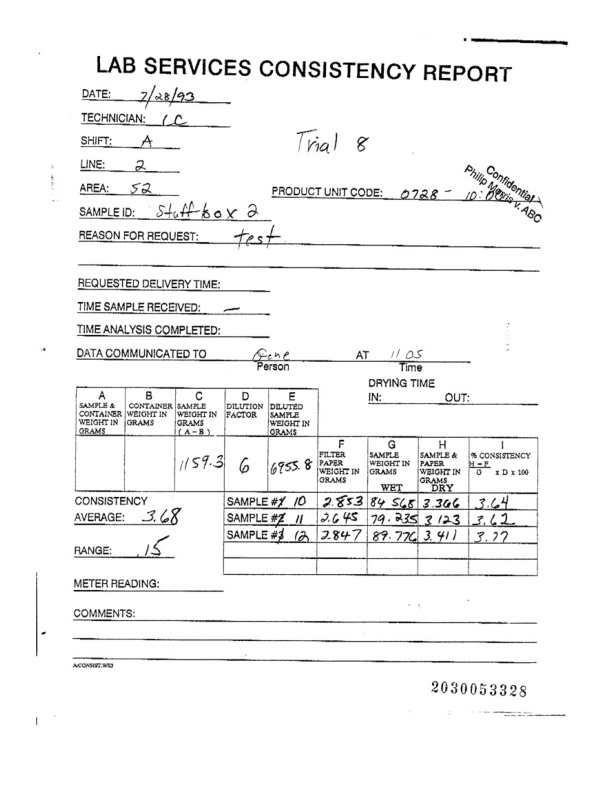


Raw Text URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/2/rawText.json
Raw Text Sample (first 200 chars):
{"DocumentMetadata": {"Pages": 1}, "Blocks": [{"BlockType": "PAGE", "Geometry": {"BoundingBox": {"Width": 1.0, "Height": 1.0, "Left": 0.0, "Top": 0.0}, "Polygon": [{"X": 1.805609528560126e-08, "Y": 0....
(truncated)

Parsed Text URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/pages/2/result.json
text:  "# LAB SERVICES CONSISTENCY REPORT \n\nDATE: 2/28/93\n TECHNICIAN: CC\n SHIFT: A\nTrial 8\n LINE: 2\n AREA: 52\nPRODUCT UNIT CODE:\n0728\n SAMPLE ID:\nstuff box 2\n REASON FOR REQUEST\ntest\n\nREQUESTED DELIVERY TIME:\n\nTIME SAMPLE RECEIVED:\n-\n TIME ANALYSIS COMPLETED:\n\nDATA COMMUNICATED TO\nGone\nAT 105\n\nPerson\nTime\n\nDRYING TIME\n\n\n\n\nA\tB\tC\tD\tE\tIN:\tOUT:\nSAMPLE &\tCONTAINER\tSAMPLE\tDILUTION\tDILUTED\nCONTAINER\tWEIGHT IN\tWEIGHT IN\tFACTOR\tSAMPLE\nWEIGHT IN\tGRAMS\tGRAMS\tWEIGHT IN\nGR

In [13]:
# Preview the OCR output files for the first page
first_page_id = list(document.pages.keys())[0]
first_page = document.pages[first_page_id]

# Helper function to parse S3 URIs
def parse_s3_uri(uri):
    parts = uri.replace("s3://", "").split("/")
    bucket = parts[0]
    key = "/".join(parts[1:])
    return bucket, key

print(f"Previewing OCR output files for page {first_page_id}:")
print(f"\nImage URI: {first_page.image_uri}")
# Display the image at 50% size
from IPython.display import Image, display
bucket, key = parse_s3_uri(first_page.image_uri)
image_obj = s3_client.get_object(Bucket=bucket, Key=key)
image_data = image_obj['Body'].read()
display(Image(data=image_data, width=400))  # Display at 50% size (assuming original is ~800px)

print(f"\nRaw Text URI: {first_page.raw_text_uri}")
# Get raw text content
bucket, key = parse_s3_uri(first_page.raw_text_uri)
raw_text_obj = s3_client.get_object(Bucket=bucket, Key=key)
raw_text_data = raw_text_obj['Body'].read().decode('utf-8')
print("Raw Text Sample (first 200 chars):")
print(raw_text_data[:200] + "...\n(truncated)")

print(f"\nParsed Text URI: {first_page.parsed_text_uri}")
# Get parsed text content
bucket, key = parse_s3_uri(first_page.parsed_text_uri)
parsed_text_obj = s3_client.get_object(Bucket=bucket, Key=key)
parsed_text_data = json.loads(parsed_text_obj['Body'].read().decode('utf-8'))

for key, value in parsed_text_data.items() :
    print(f"{key}: ", json.dumps(value[:500] + "...\n(truncated)"))


## 6. Classify the Document with Bedrock Backend

In [14]:
# Create classification service with Bedrock backend
classification_service = classification.ClassificationService(
    config=get_config(),
    backend="bedrock"  # Using real Bedrock backend
)

# Classify the document
print("\nClassifying document...")
start_time = time.time()
document = classification_service.classify_document(document)
classification_time = time.time() - start_time

print(f"Classification completed in {classification_time:.2f} seconds")
print(f"Document status: {document.status.value}")

# Show classification results
print("\nPage classification results:")
for page_id, page in document.pages.items():
    print(f"Page {page_id}: {page.classification} (confidence: {page.confidence:.2f})")

print("\nSections detected:")
for section in document.sections:
    print(f"Section {section.section_id}: {section.classification}")
    print(f"  Pages: {section.page_ids}")
    print(f"  Confidence: {section.confidence:.2f}")


Classifying document...


Bedrock throttling occurred (attempt 1/8). Error: Too many requests, please wait before trying again.. Backing off for 4.23s
Bedrock throttling occurred (attempt 1/8). Error: Too many requests, please wait before trying again.. Backing off for 4.00s
Bedrock throttling occurred (attempt 1/8). Error: Too many requests, please wait before trying again.. Backing off for 4.20s
Bedrock throttling occurred (attempt 1/8). Error: Too many requests, please wait before trying again.. Backing off for 4.16s
Bedrock throttling occurred (attempt 1/8). Error: Too many requests, please wait before trying again.. Backing off for 4.16s
Bedrock throttling occurred (attempt 1/8). Error: Too many requests, please wait before trying again.. Backing off for 4.18s
Bedrock throttling occurred (attempt 2/8). Error: Too many requests, please wait before trying again.. Backing off for 8.50s
Bedrock throttling occurred (attempt 2/8). Error: Too many requests, please wait before trying again.. Backing off for 8.17s


Classification completed in 108.26 seconds
Document status: CLASSIFIED

Page classification results:
Page 2: generic (confidence: 1.00)
Page 10: letter (confidence: 1.00)
Page 9: generic (confidence: 1.00)
Page 4: generic (confidence: 1.00)
Page 1: letter (confidence: 1.00)
Page 7: generic (confidence: 1.00)
Page 3: email (confidence: 1.00)
Page 5: invoice (confidence: 1.00)
Page 8: generic (confidence: 1.00)
Page 6: generic (confidence: 1.00)

Sections detected:
Section 1: letter
  Pages: ['1']
  Confidence: 1.00
Section 2: generic
  Pages: ['2']
  Confidence: 1.00
Section 3: email
  Pages: ['3']
  Confidence: 1.00
Section 4: generic
  Pages: ['4']
  Confidence: 1.00
Section 5: invoice
  Pages: ['5']
  Confidence: 1.00
Section 6: generic
  Pages: ['6', '7', '8', '9']
  Confidence: 1.00
Section 7: letter
  Pages: ['10']
  Confidence: 1.00


## 7. Extract Information from Document Sections

In [15]:
# Create extraction service with real Bedrock
extraction_service = extraction.ExtractionService(config=get_config())

print("\nExtracting information from document sections...")

# Create individual document for each section (following our pattern for Lambda functions)
extracted_results = {}

n=0
for section in document.sections:
    print(f"\nProcessing section {section.section_id} (class: {section.classification})")
    
    # Create a section-specific document
    section_document = Document(
        id=document.id,
        input_bucket=document.input_bucket,
        input_key=document.input_key,
        output_bucket=document.output_bucket,
        status=document.status,
        sections=[section]
    )
    
    # Add only pages needed for this section
    needed_pages = {}
    for page_id in section.page_ids:
        if page_id in document.pages:
            needed_pages[page_id] = document.pages[page_id]
    section_document.pages = needed_pages
    
    # Process section
    start_time = time.time()
    section_document = extraction_service.process_document_section(
        document=section_document,
        section_id=section.section_id
    )
    extraction_time = time.time() - start_time
    
    print(f"Extraction completed in {extraction_time:.2f} seconds")
    
    # Get the updated section
    updated_section = section_document.sections[0]
    print(f"Extraction result URI: {updated_section.extraction_result_uri}")
    
    # Store results for later use
    extracted_results[section.section_id] = {
        "section": updated_section,
        "result_uri": updated_section.extraction_result_uri
    }
    n += 1
    print(f"Processed {n} sections")
    if n >= 3:
        print("\nExtraction for max 3 sections complete.")
        break

print("\nExtraction for all sections complete.")


Extracting information from document sections...

Processing section 1 (class: letter)
Extraction completed in 6.00 seconds
Extraction result URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/1/result.json
Processed 1 sections

Processing section 2 (class: generic)
Extraction completed in 13.60 seconds
Extraction result URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/2/result.json
Processed 2 sections

Processing section 3 (class: email)
Extraction completed in 13.76 seconds
Extraction result URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/3/result.json
Processed 3 sections

Extraction for max 3 sections complete.

Extraction for all sections complete.


## 8. Load Extraction Results from S3

In [16]:
# Helper function to parse S3 URIs
def parse_s3_uri(uri):
    parts = uri.replace("s3://", "").split("/")
    bucket = parts[0]
    key = "/".join(parts[1:])
    return bucket, key

# Helper function to load JSON from S3
def load_json_from_s3(uri):
    bucket, key = parse_s3_uri(uri)
    response = s3_client.get_object(Bucket=bucket, Key=key)
    content = response['Body'].read().decode('utf-8')
    return json.loads(content)

print("Loading extraction results from S3...\n")

for section_id, data in extracted_results.items():
    # Load the extraction results from S3
    uri = data['result_uri']
    try:
        result_data = load_json_from_s3(uri)
        
        # Extract the inference results
        if "inference_result" in result_data:
            extraction_results = result_data["inference_result"]
        else:
            extraction_results = result_data
            
        # Print out section and extraction results
        print(f"Results for section {section_id} (class: {data['section'].classification})")
        print(f"S3 URI: {uri}")
        print("Extracted attributes:")
        for key, value in extraction_results.items():
            print(f"  {key}: {value}")
        print()
    except Exception as e:
        print(f"Error loading results from {uri}: {str(e)}")
        print()

Loading extraction results from S3...

Results for section 1 (class: letter)
S3 URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/1/result.json
Extracted attributes:
  sender_name: Will E. Clark
  sender_address: 206 Maple Street P.O. Box 1056 Murray, Kentucky 42071-1056
  recipient_name: The Honorable Wendell H. Ford
  recipient_address: United States Senate Washington, D. C. 20510
  date: 10/31/1995
  subject: Opposition to the 'Commitment to our Children' petition
  letter_type: Opposition
  signature: Will E. Clark
  cc: None
  reference_number: TNJB 0008497

Results for section 2 (class: generic)
S3 URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/2/result.json
Extracted attributes:
  document_type: LAB SERVICES CONSISTENCY REPORT
  document_date: 07/28/1993
  title: LAB SERVICES CONSISTENCY REPORT
  content_summary: This document is a consistency report for lab services, detailing various measure

## 9. Final Document Status Summary

In [17]:
# Update document status to PROCESSED
document.status = Status.PROCESSED

# Update document sections with extraction results
for section_id, data in extracted_results.items():
    # Find section in document
    for i, section in enumerate(document.sections):
        if section.section_id == section_id:
            document.sections[i] = data['section']

# Display final document state
print("Final Document State:")
print(f"Document ID: {document.id}")
print(f"Status: {document.status.value}")
print(f"Number of pages: {document.num_pages}")
print(f"Number of sections: {len(document.sections)}")

print("\nSection summary:")
for section in document.sections:
    print(f"  Section {section.section_id}: {section.classification}")
    print(f"    Pages: {section.page_ids}")
    print(f"    Extraction result URI: {section.extraction_result_uri}")

# Show document serialization capabilities
print("\nDocument can be serialized to JSON:")
document_dict = document.to_dict()
document_json = json.dumps(document_dict, indent=2)[:500]  # Truncate for display
print(f"{document_json}...")
print("(truncated for display)")

Final Document State:
Document ID: doc-insurance-package
Status: PROCESSED
Number of pages: 10
Number of sections: 7

Section summary:
  Section 1: letter
    Pages: ['1']
    Extraction result URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/1/result.json
  Section 2: generic
    Pages: ['2']
    Extraction result URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/2/result.json
  Section 3: email
    Pages: ['3']
    Extraction result URI: s3://idp-example-output-912625584728-us-west-2/sample-2025-04-11_20-13-00.pdf/sections/3/result.json
  Section 4: generic
    Pages: ['4']
    Extraction result URI: None
  Section 5: invoice
    Pages: ['5']
    Extraction result URI: None
  Section 6: generic
    Pages: ['6', '7', '8', '9']
    Extraction result URI: None
  Section 7: letter
    Pages: ['10']
    Extraction result URI: None

Document can be serialized to JSON:
{
  "id": "doc-insurance-package",
  "

## 10. Clean Up (Optional)

If you want to clean up the resources created during this demo, run the following cell.

In [18]:
# Function to delete objects in a bucket
def delete_bucket_objects(bucket_name):
    try:
        # List all objects in the bucket
        response = s3_client.list_objects_v2(Bucket=bucket_name)
        if 'Contents' in response:
            delete_keys = {'Objects': [{'Key': obj['Key']} for obj in response['Contents']]}
            s3_client.delete_objects(Bucket=bucket_name, Delete=delete_keys)
            print(f"Deleted all objects in bucket {bucket_name}")
        else:
            print(f"Bucket {bucket_name} is already empty")
            
        # Delete bucket
        s3_client.delete_bucket(Bucket=bucket_name)
        print(f"Deleted bucket {bucket_name}")
    except Exception as e:
        print(f"Error cleaning up bucket {bucket_name}: {str(e)}")

# Uncomment the following lines to delete the buckets
# print("Cleaning up resources...")
# delete_bucket_objects(input_bucket_name)
# delete_bucket_objects(output_bucket_name)
# print("Cleanup complete")

## Conclusion

This notebook demonstrates the end-to-end processing flow using real AWS services and the unified Document model:

1. **Document Creation** - Initialize a Document object with input/output locations
2. **OCR Processing** - Convert PDF to text using AWS Textract via OcrService
3. **Classification** - Identify document types and sections with Claude via ClassificationService
4. **Extraction** - Extract structured information with Claude via ExtractionService
5. **Document Model** - Document object is consistently used between all services
6. **Result Storage** - Extraction results are stored in S3 with URIs tracked in the Document

Key benefits of this approach:

1. **Modularity** - Each service has a clear responsibility
2. **Consistency** - Same data model flows through the entire pipeline
3. **Performance** - Focused document pattern reduces resource usage
4. **Flexibility** - Support for multiple backends (Bedrock, SageMaker)
5. **Maintainability** - Standardized patterns across services

This example uses a real workflow with:
1. Real S3 buckets (created specifically for this demo)
2. Real AWS Textract OCR processing
3. Real Claude 3 Sonnet inferencing via Bedrock
4. A real document sample (insurance_package.pdf)

## Conclusion

This notebook demonstrates the end-to-end processing flow using the unified Document model:

1. **Document Creation** - Initialize a Document object with input/output locations
2. **OCR Processing** - Convert PDF to text using OcrService
3. **Classification** - Identify document types and sections with ClassificationService
4. **Extraction** - Extract structured information with ExtractionService
5. **Document Model** - Document object is consistently used between all services
6. **Result Storage** - Extraction results are stored in S3 with URIs tracked in the Document

Key benefits of this approach:

1. **Modularity** - Each service has a clear responsibility
2. **Consistency** - Same data model flows through the entire pipeline
3. **Performance** - Focused document pattern reduces resource usage
4. **Flexibility** - Support for multiple backends (Bedrock, SageMaker)
5. **Maintainability** - Standardized patterns across services

To use in a real environment, you would need:
1. Valid AWS credentials
2. Access to required AWS services (S3, Bedrock, etc.)
3. Configuration stored in DynamoDB
4. Real document files in S3